***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

from xgboost import XGBClassifier
from xgboost import plot_importance

Using TensorFlow backend.
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression(random_state=0)
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier(random_state=0)
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier(random_state=0)
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier(random_state=0)
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier(random_state=0)
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier(random_state=0)
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    roc_auc =auc(fpr, tpr)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

### HTML Read Data

In [4]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

Shape of HTML dataset: (43491, 1461)


In [8]:
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)

In [36]:
[col for col in df_html.columns if 'out_of_domain' in col]

['a_href_out_of_domain',
 'area_href_out_of_domain',
 'audio_src_out_of_domain',
 'base_href_out_of_domain',
 'embed_src_out_of_domain',
 'form_action_out_of_domain',
 'frame_src_out_of_domain',
 'iframe_src_out_of_domain',
 'img_src_out_of_domain',
 'img_srcset_out_of_domain',
 'link_href_out_of_domain',
 'object_data_out_of_domain',
 'script_src_out_of_domain',
 'source_src_out_of_domain',
 'source_srcset_out_of_domain',
 'video_src_out_of_domain']

In [39]:
html_columns=['a_count','div_count','embed_count','frame_count','iframe_count','img_count','input_count',
              'link_count','meta_count','object_count','style_count','title_count','total_count','total_href',
              'total_img_src','iframe_hidden_true','script_type_text/javascript','a_href_out_of_domain',
 'area_href_out_of_domain',
 'audio_src_out_of_domain',
 'base_href_out_of_domain',
 'embed_src_out_of_domain',
 'form_action_out_of_domain',
 'frame_src_out_of_domain',
 'iframe_src_out_of_domain',
 'img_src_out_of_domain',
 'img_srcset_out_of_domain',
 'link_href_out_of_domain',
 'object_data_out_of_domain',
 'script_src_out_of_domain',
 'source_src_out_of_domain',
 'source_srcset_out_of_domain',
 'video_src_out_of_domain','Target']

In [40]:
df_html=df_html[html_columns]

### JavaScript read data

In [41]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)

In [42]:
js_columns=[ 'dom_function_document.createElement(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.setInterval(',
 'dom_function_window.setTimeout(',

 'js_function_.charCodeAt(',
 'js_function_.concat(',
 'js_function_.exec(',
 'js_function_.link(',
 'js_function_.search(',
 'js_function_.substring(',


 'js_function_escape(',
 'js_function_eval(',
 'js_function_parseInt(',
 'js_function_String.fromCharCode(',
 'js_function_unescape(',
'js_function_.replace(','Target'
]

In [43]:
df_js=df_js[js_columns]

In [44]:
df=pd.concat([df_js,df_html],axis=1,join='inner')
df['Target_z']=df[['Target','Target']].apply(max,axis=1)
df.drop(['Target','Target'],axis=1,inplace=True)
df.rename(columns={'Target_z':'Target'},inplace=True)

In [45]:
df_sel=df.copy(deep=True)

In [46]:
df_sel.columns

Index(['dom_function_document.createElement(', 'dom_function_document.write(',
       'dom_function_window.addEventListener(',
       'dom_function_window.setInterval(', 'dom_function_window.setTimeout(',
       'js_function_.charCodeAt(', 'js_function_.concat(',
       'js_function_.exec(', 'js_function_.link(', 'js_function_.search(',
       'js_function_.substring(', 'js_function_escape(', 'js_function_eval(',
       'js_function_parseInt(', 'js_function_String.fromCharCode(',
       'js_function_unescape(', 'js_function_.replace(', 'a_count',
       'div_count', 'embed_count', 'frame_count', 'iframe_count', 'img_count',
       'input_count', 'link_count', 'meta_count', 'object_count',
       'style_count', 'title_count', 'total_count', 'total_href',
       'total_img_src', 'iframe_hidden_true', 'script_type_text/javascript',
       'a_href_out_of_domain', 'area_href_out_of_domain',
       'audio_src_out_of_domain', 'base_href_out_of_domain',
       'embed_src_out_of_domain', 'form_

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [49]:
train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [53]:
columns=df_sel.columns.values.tolist()
columns.remove('Target')

In [54]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.91279516074554
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25506  2332    27838
True         508  4221     4729
__all__    26014  6553    32567

Accuracy of the model for test data is: 0.9097273397199706
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6354   586     6940
True         149  1053     1202
__all__     6503  1639     8142



Logistic Regression
Accuracy of the model for training data is: 0.8925906592563024
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25446  2392    27838
True        1106  3623     4729
__all__    26552  6015    32567

Accuracy of the model for test data is: 0.8931466470154753
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6342   598     6940
True         272   930     1202
__all__     6614  1528     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9248625909663156
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25615  2223    27838
True         224  4505     4729
__all__    25839  6728    32567

Accuracy of the model for test data is: 0.9136575779906657
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6381   559     6940
True         144  1058     1202
__all__     6525  1617     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8980870206036786
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25580  2258    27838
True        1061  3668     4729
__all__    26641  5926    32567

Accuracy of the model for test data is: 0.8981822647998035
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6379   561     6940
True         268   934     1202
__all__     6647  1495     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9075444468326834
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25579  2259    27838
True         752  3977     4729
__all__    26331  6236    32567

Accuracy of the model for test data is: 0.9069024809629084
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6380   560     6940
True         198  1004     1202
__all__     6578  1564     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.927134829735622
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25623  2215    27838
True         158  4571     4729
__all__    25781  6786    32567

Accuracy of the model for test data is: 0.9125521984770326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6375   565     6940
True         147  1055     1202
__all__     6522  1620     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9247704731783707
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25615  2223    27838
True         227  4502     4729
__all__    25842  6725    32567

Accuracy of the model for test data is: 0.9125521984770326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6373   567     6940
True         145  1057     1202
__all__     6518  1624     8142



Neural Network-1
The accuracy of the model on training data is: 0.9099702152503947


Predicted  False  True  __all__
Actual                         
False      25430  2408    27838
True         524  4205     4729
__all__    25954  6613    32567

The accuracy of the model on test data is: 0.903954802259887


Predicted  False  True  __all__
Actual                         
False       6329   611     6940
True         171  1031     1202
__all__     6500  1642     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [55]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [56]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912795,4221.0,25506.0,2332.0,508.0,0.083770,0.107422
LogisticRegression,0.892591,3623.0,25446.0,2392.0,1106.0,0.085926,0.233876
RandomForestClassifier,0.924863,4505.0,25615.0,2223.0,224.0,0.079855,0.047367
AdaBoostClassifier,0.898087,3668.0,25580.0,2258.0,1061.0,0.081112,0.224360
GradientBoostingClassifier,0.907544,3977.0,25579.0,2259.0,752.0,0.081148,0.159019
ExtraTreeClassifier,0.927135,4571.0,25623.0,2215.0,158.0,0.079567,0.033411
BaggingClassifier,0.924770,4502.0,25615.0,2223.0,227.0,0.079855,0.048002
Neural Network-1,0.909970,4205.0,25430.0,2408.0,524.0,0.086500,0.110806


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.909727,1053.0,6354.0,586.0,149.0,0.084438,0.123960,0.895801,0.700313
LogisticRegression,0.893147,930.0,6342.0,598.0,272.0,0.086167,0.226290,0.843772,0.624652
RandomForestClassifier,0.913658,1058.0,6381.0,559.0,144.0,0.080548,0.119800,0.899826,0.711030
AdaBoostClassifier,0.898182,934.0,6379.0,561.0,268.0,0.080836,0.222962,0.848101,0.637873
GradientBoostingClassifier,0.906902,1004.0,6380.0,560.0,198.0,0.080692,0.164725,0.877291,0.679475
ExtraTreeClassifier,0.912552,1055.0,6375.0,565.0,147.0,0.081412,0.122296,0.898146,0.707549
BaggingClassifier,0.912552,1057.0,6373.0,567.0,145.0,0.081700,0.120632,0.898834,0.708115
Neural Network-1,0.903955,1031.0,6329.0,611.0,171.0,0.088040,0.142263,0.884848,0.680469


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [57]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [58]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [59]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.5994144694302752
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      26943   895    27838
True       21408  6430    27838
__all__    48351  7325    55676

Accuracy of the model for test data is: 0.8427904691721936
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6663   277     6940
True        1003   199     1202
__all__     7666   476     8142



Logistic Regression
Accuracy of the model for training data is: 0.8859652273870249
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22755   5083    27838
True        1266  26572    27838
__all__    24021  31655    55676

Accuracy of the model for test data is: 0.8375092114959469
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5681  1259     6940
True          64  1138     1202
__all__     5745  2397     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9510201882319133
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25260   2578    27838
True         149  27689    27838
__all__    25409  30267    55676

Accuracy of the model for test data is: 0.9016212232866617
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6247   693     6940
True         108  1094     1202
__all__     6355  1787     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9007651411739349
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23681   4157    27838
True        1368  26470    27838
__all__    25049  30627    55676

Accuracy of the model for test data is: 0.861704740849914
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5907  1033     6940
True          93  1109     1202
__all__     6000  2142     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9226596738271428
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24432   3406    27838
True         900  26938    27838
__all__    25332  30344    55676

Accuracy of the model for test data is: 0.883075411446819
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6083   857     6940
True          95  1107     1202
__all__     6178  1964     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9518104748904376
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25268   2570    27838
True         113  27725    27838
__all__    25381  30295    55676

Accuracy of the model for test data is: 0.9016212232866617
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6246   694     6940
True         107  1095     1202
__all__     6353  1789     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9508226165672822
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25263   2575    27838
True         163  27675    27838
__all__    25426  30250    55676

Accuracy of the model for test data is: 0.8999017440432326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6226   714     6940
True         101  1101     1202
__all__     6327  1815     8142



Neural Network-1
The accuracy of the model on training data is: 0.9344960126445865


Predicted  False   True  __all__
Actual                          
False      24310   3528    27838
True         119  27719    27838
__all__    24429  31247    55676

The accuracy of the model on test data is: 0.8771800540407763


Predicted  False  True  __all__
Actual                         
False       6008   932     6940
True          68  1134     1202
__all__     6076  2066     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [60]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [61]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.599414,6430.0,26943.0,895.0,21408.0,0.032150,0.769021
LogisticRegression,0.885965,26572.0,22755.0,5083.0,1266.0,0.182592,0.045477
RandomForestClassifier,0.951020,27689.0,25260.0,2578.0,149.0,0.092607,0.005352
AdaBoostClassifier,0.900765,26470.0,23681.0,4157.0,1368.0,0.149328,0.049141
GradientBoostingClassifier,0.922660,26938.0,24432.0,3406.0,900.0,0.122351,0.032330
ExtraTreeClassifier,0.951810,27725.0,25268.0,2570.0,113.0,0.092320,0.004059
BaggingClassifier,0.950823,27675.0,25263.0,2575.0,163.0,0.092499,0.005855
Neural Network-1,0.934496,27719.0,24310.0,3528.0,119.0,0.126733,0.004275


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.842790,199.0,6663.0,277.0,1003.0,0.039914,0.834443,0.562822,0.189970
LogisticRegression,0.837509,1138.0,5681.0,1259.0,64.0,0.181412,0.053245,0.882672,0.595675
RandomForestClassifier,0.901621,1094.0,6247.0,693.0,108.0,0.099856,0.089850,0.905147,0.694472
AdaBoostClassifier,0.861705,1109.0,5907.0,1033.0,93.0,0.148847,0.077371,0.886891,0.623398
GradientBoostingClassifier,0.883075,1107.0,6083.0,857.0,95.0,0.123487,0.079035,0.898739,0.661235
ExtraTreeClassifier,0.901621,1095.0,6246.0,694.0,107.0,0.100000,0.089018,0.905491,0.694782
BaggingClassifier,0.899902,1101.0,6226.0,714.0,101.0,0.102882,0.084027,0.906546,0.693002
Neural Network-1,0.877180,1134.0,6008.0,932.0,68.0,0.134294,0.056572,0.904567,0.659596


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [62]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [63]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)

## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

Shape after undersampling (9458, 50)
K-Nearest Neighbors
Accuracy of the model for training data is: 0.5698879255656587
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4594   135     4729
True        3933   796     4729
__all__     8527   931     9458

Accuracy of the model for test data is: 0.8386145910095799
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6656   284     6940
True        1030   172     1202
__all__     7686   456     8142



Logistic Regression
Accuracy of the model for training data is: 0.8796785789807571
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3816   913     4729
True         225  4504     4729
__all__     4041  5417     9458

Accuracy of the model for test data is: 0.8279292557111275
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5596  1344     6940
True          57  1145     1202
__all__     5653  2489     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9478748149714528
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4290   439     4729
True          54  4675     4729
__all__     4344  5114     9458

Accuracy of the model for test data is: 0.8870056497175142
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6106   834     6940
True          86  1116     1202
__all__     6192  1950     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.8879255656587016
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3959   770     4729
True         290  4439     4729
__all__     4249  5209     9458

Accuracy of the model for test data is: 0.8593711618766888
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5876  1064     6940
True          81  1121     1202
__all__     5957  2185     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9083315711566927
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4132   597     4729
True         270  4459     4729
__all__     4402  5056     9458

Accuracy of the model for test data is: 0.8768115942028986
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6018   922     6940
True          81  1121     1202
__all__     6099  2043     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.9514696553182491
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4296   433     4729
True          26  4703     4729
__all__     4322  5136     9458

Accuracy of the model for test data is: 0.8949889462048637
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6169   771     6940
True          84  1118     1202
__all__     6253  1889     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9468175089871008
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4288   441     4729
True          62  4667     4729
__all__     4350  5108     9458

Accuracy of the model for test data is: 0.8899533284205355
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6134   806     6940
True          90  1112     1202
__all__     6224  1918     8142



Neural Network-1
The accuracy of the model on training data is: 0.9162613660519359


Predicted  False  True  __all__
Actual                         
False       4021   708     4729
True          84  4645     4729
__all__     4105  5353     9458

The accuracy of the model on test data is: 0.8489314664701547


Predicted  False  True  __all__
Actual                         
False       5765  1175     6940
True          55  1147     1202
__all__     5820  2322     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [64]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [65]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.569888,796.0,4594.0,135.0,3933.0,0.028547,0.831677
LogisticRegression,0.879679,4504.0,3816.0,913.0,225.0,0.193064,0.047579
RandomForestClassifier,0.947875,4675.0,4290.0,439.0,54.0,0.092831,0.011419
AdaBoostClassifier,0.887926,4439.0,3959.0,770.0,290.0,0.162825,0.061324
GradientBoostingClassifier,0.908332,4459.0,4132.0,597.0,270.0,0.126242,0.057095
ExtraTreeClassifier,0.951470,4703.0,4296.0,433.0,26.0,0.091563,0.005498
BaggingClassifier,0.946818,4667.0,4288.0,441.0,62.0,0.093254,0.013111
Neural Network-1,0.916261,4645.0,4021.0,708.0,84.0,0.149715,0.017763


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.838615,172.0,6656.0,284.0,1030.0,0.040922,0.856905,0.551086,0.157628
LogisticRegression,0.827929,1145.0,5596.0,1344.0,57.0,0.193660,0.047421,0.879460,0.584353
RandomForestClassifier,0.887006,1116.0,6106.0,834.0,86.0,0.120173,0.071547,0.904140,0.671832
AdaBoostClassifier,0.859371,1121.0,5876.0,1064.0,81.0,0.153314,0.067388,0.889649,0.623873
GradientBoostingClassifier,0.876812,1121.0,6018.0,922.0,81.0,0.132853,0.067388,0.899880,0.654377
ExtraTreeClassifier,0.894989,1118.0,6169.0,771.0,84.0,0.111095,0.069884,0.909511,0.688283
BaggingClassifier,0.889953,1112.0,6134.0,806.0,90.0,0.116138,0.074875,0.904493,0.676261
Neural Network-1,0.848931,1147.0,5765.0,1175.0,55.0,0.169308,0.045757,0.892467,0.616698


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [66]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [67]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 4.975 seconds
Elapsed: 00:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.ex

In [68]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [69]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [70]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [71]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [72]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.3)

X.shape

The train/test split ratio is 70:30


(40709, 48)

In [73]:
feature_name

['total_href / total_count',
 'link_href_out_of_domain / link_count',
 'img_count / total_count',
 'img_count + total_count',
 'div_count + total_count',
 'a_href_out_of_domain / total_href',
 'a_href_out_of_domain / total_count',
 'a_count / total_count',
 'total_img_src / total_count',
 'total_count + total_img_src',
 'title_count + total_count',
 'style_count + total_count',
 'source_srcset_out_of_domain + total_count',
 'script_type_text/javascript + total_count',
 'script_src_out_of_domain + total_count',
 'meta_count + total_count',
 'link_href_out_of_domain / total_href',
 'link_href_out_of_domain + total_count',
 'link_count + total_count',
 'js_function_unescape( + total_count',
 'js_function_parseInt( + total_count',
 'js_function_eval( + total_count',
 'js_function_escape( + total_count',
 'js_function_String.fromCharCode( + total_count',
 'js_function_.substring( + total_count',
 'js_function_.search( + total_count',
 'js_function_.replace( + total_count',
 'js_function_.li

In [74]:
fs=fs.reindex(df_sel.index.values)

train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [75]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])


feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.8715878036048761
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27666   172    27838
True        4010   719     4729
__all__    31676   891    32567

Accuracy of the model for test data is: 0.8647752394988946
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6885    55     6940
True        1046   156     1202
__all__     7931   211     8142



Logistic Regression
Accuracy of the model for training data is: 0.8736758067982927
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24607  3231    27838
True         883  3846     4729
__all__    25490  7077    32567

Accuracy of the model for test data is: 0.8742323753377549
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6128   812     6940
True         212   990     1202
__all__     6340  1802     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.924586237602481
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25617  2221    27838
True         235  4494     4729
__all__    25852  6715    32567

Accuracy of the model for test data is: 0.9123065585851142
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6369   571     6940
True         143  1059     1202
__all__     6512  1630     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9024472625664016
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25513  2325    27838
True         852  3877     4729
__all__    26365  6202    32567

Accuracy of the model for test data is: 0.9027266028002948
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6365   575     6940
True         217   985     1202
__all__     6582  1560     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9092332729450057
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25593  2245    27838
True         711  4018     4729
__all__    26304  6263    32567

Accuracy of the model for test data is: 0.9083763203144191
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6381   559     6940
True         187  1015     1202
__all__     6568  1574     8142

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/utils.py", line 713, in log_errors
    yield
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/distributed/client.py", line 1223, in _close
    quiet_exceptions=(CancelledError,),
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 584, in with_timeout
    chain_future(future_converted, result)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 166, in chain_future
    future_add_done_callback(a, copy)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 262, in future_add_done_callback
    callback(future)
  File "/nethomes/darshan/anaconda3/lib/python3.6/site-packages/tornado/concurrent.py", line 160, in copy
    elif a.exception() is not None:
concurrent.futures._base.CancelledError
Exception ignored in: <bound method



ExtraTree Classifier
Accuracy of the model for training data is: 0.927134829735622
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25623  2215    27838
True         158  4571     4729
__all__    25781  6786    32567

Accuracy of the model for test data is: 0.912183738639155
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6367   573     6940
True         142  1060     1202
__all__     6509  1633     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9249547087542604
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25617  2221    27838
True         223  4506     4729
__all__    25840  6727    32567

Accuracy of the model for test data is: 0.9119380987472365
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6367   573     6940
True         144  1058     1202
__all__     6511  1631     8142



Neural Network-1
The accuracy of the model on training data is: 0.888383946956626


Predicted  False  True  __all__
Actual                         
False      24634  3204    27838
True         431  4298     4729
__all__    25065  7502    32567

The accuracy of the model on test data is: 0.884180790960452


Predicted  False  True  __all__
Actual                         
False       6121   819     6940
True         124  1078     1202
__all__     6245  1897     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [76]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [77]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871588,719.0,27666.0,172.0,4010.0,0.006179,0.847959
LogisticRegression,0.873676,3846.0,24607.0,3231.0,883.0,0.116064,0.186720
RandomForestClassifier,0.924586,4494.0,25617.0,2221.0,235.0,0.079783,0.049693
AdaBoostClassifier,0.902447,3877.0,25513.0,2325.0,852.0,0.083519,0.180165
GradientBoostingClassifier,0.909233,4018.0,25593.0,2245.0,711.0,0.080645,0.150349
ExtraTreeClassifier,0.927135,4571.0,25623.0,2215.0,158.0,0.079567,0.033411
BaggingClassifier,0.924955,4506.0,25617.0,2221.0,223.0,0.079783,0.047156
Neural Network-1,0.888384,4298.0,24634.0,3204.0,431.0,0.115094,0.091140


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.864775,156.0,6885.0,55.0,1046.0,0.007925,0.870216,0.560929,0.272071
LogisticRegression,0.874232,990.0,6128.0,812.0,212.0,0.117003,0.176373,0.853312,0.603808
RandomForestClassifier,0.912307,1059.0,6369.0,571.0,143.0,0.082277,0.118968,0.899377,0.708100
AdaBoostClassifier,0.902727,985.0,6365.0,575.0,217.0,0.082853,0.180532,0.868307,0.663943
GradientBoostingClassifier,0.908376,1015.0,6381.0,559.0,187.0,0.080548,0.155574,0.881939,0.686179
ExtraTreeClassifier,0.912184,1060.0,6367.0,573.0,142.0,0.082565,0.118136,0.899649,0.708094
BaggingClassifier,0.911938,1058.0,6367.0,573.0,144.0,0.082565,0.119800,0.898817,0.706944
Neural Network-1,0.884181,1078.0,6121.0,819.0,124.0,0.118012,0.103161,0.889414,0.653541


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [78]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

distributed.core - INFO - Event loop was unresponsive in Nanny for 101.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 101.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 101.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 101.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 101.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

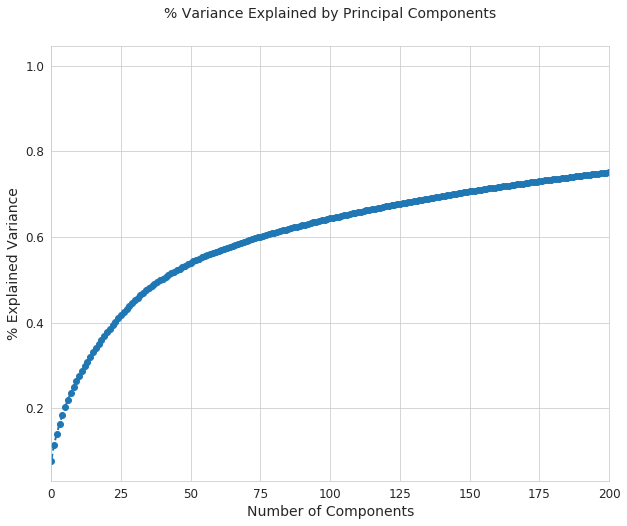

In [79]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [80]:
pca=PCA(n_components=300,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 300 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 300 components is: 0.81200668491615


In [81]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [82]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,300).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.9133171615438941
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25512  2326    27838
True         497  4232     4729
__all__    26009  6558    32567

Accuracy of the model for test data is: 0.9078850405305822
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6340   600     6940
True         150  1052     1202
__all__     6490  1652     8142



Logistic Regression
Accuracy of the model for training data is: 0.8971044308656001
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25464  2374    27838
True         977  3752     4729
__all__    26441  6126    32567

Accuracy of the model for test data is: 0.8949889462048637
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6333   607     6940
True         248   954     1202
__all__     6581  1561     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.9244941198145362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25618  2220    27838
True         239  4490     4729
__all__    25857  6710    32567

Accuracy of the model for test data is: 0.9130434782608695
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6382   558     6940
True         150  1052     1202
__all__     6532  1610     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.9038904412442043
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25484  2354    27838
True         776  3953     4729
__all__    26260  6307    32567

Accuracy of the model for test data is: 0.9037091623679686
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6360   580     6940
True         204   998     1202
__all__     6564  1578     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.9129179844627998
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25604  2234    27838
True         602  4127     4729
__all__    26206  6361    32567

Accuracy of the model for test data is: 0.9093588798820929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6378   562     6940
True         176  1026     1202
__all__     6554  1588     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.927134829735622
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25623  2215    27838
True         158  4571     4729
__all__    25781  6786    32567

Accuracy of the model for test data is: 0.9125521984770326
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6378   562     6940
True         150  1052     1202
__all__     6528  1614     8142



Bagging Classifier
Accuracy of the model for training data is: 0.9246783553904259
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25617  2221    27838
True         232  4497     4729
__all__    25849  6718    32567

Accuracy of the model for test data is: 0.9115696389093588
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6367   573     6940
True         147  1055     1202
__all__     6514  1628     8142



Neural Network-1
The accuracy of the model on training data is: 0.9231430589191877


Predicted  False  True  __all__
Actual                         
False      25524  2314    27838
True         189  4540     4729
__all__    25713  6854    32567

The accuracy of the model on test data is: 0.9057971014492754


Predicted  False  True  __all__
Actual                         
False       6306   634     6940
True         133  1069     1202
__all__     6439  1703     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [83]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [84]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.913317,4232.0,25512.0,2326.0,497.0,0.083555,0.105096
LogisticRegression,0.897104,3752.0,25464.0,2374.0,977.0,0.085279,0.206598
RandomForestClassifier,0.924494,4490.0,25618.0,2220.0,239.0,0.079747,0.050539
AdaBoostClassifier,0.903890,3953.0,25484.0,2354.0,776.0,0.084561,0.164094
GradientBoostingClassifier,0.912918,4127.0,25604.0,2234.0,602.0,0.080250,0.127300
ExtraTreeClassifier,0.927135,4571.0,25623.0,2215.0,158.0,0.079567,0.033411
BaggingClassifier,0.924678,4497.0,25617.0,2221.0,232.0,0.079783,0.049059
Neural Network-1,0.923143,4540.0,25524.0,2314.0,189.0,0.083124,0.039966


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.907885,1052.0,6340.0,600.0,150.0,0.086455,0.124792,0.894376,0.695738
LogisticRegression,0.894989,954.0,6333.0,607.0,248.0,0.087464,0.206323,0.853107,0.636386
RandomForestClassifier,0.913043,1052.0,6382.0,558.0,150.0,0.080403,0.124792,0.897402,0.707875
AdaBoostClassifier,0.903709,998.0,6360.0,580.0,204.0,0.083573,0.169717,0.873355,0.670110
GradientBoostingClassifier,0.909359,1026.0,6378.0,562.0,176.0,0.080980,0.146423,0.886299,0.691683
ExtraTreeClassifier,0.912552,1052.0,6378.0,562.0,150.0,0.080980,0.124792,0.897114,0.706701
BaggingClassifier,0.911570,1055.0,6367.0,573.0,147.0,0.082565,0.122296,0.897569,0.705219
Neural Network-1,0.905797,1069.0,6306.0,634.0,133.0,0.091354,0.110649,0.898998,0.696012


In [85]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')